In [1]:
from osgeo import gdal, osr
import os
import io
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import sys, os
sys.path.append('/Volumes/EllenBackup/ANALYSIS/ANALYSIS/IS2/S2/')
import peakdet as f1
from scipy.stats import skew, skewtest, iqr
import pandas as pd
import numpy as np
from PIL import Image


use bash to translate TCI from jp2 to geotif (you can just run this in your terminal if you aren't using jupyter notebooks)

In [2]:
!gdal_translate ~/Downloads/T10XEM_20190903T214049_TCI.jp2 ~/Downloads/T10XEM_20190903T214049_TCI.tif

Input file size is 10980, 10980
0...10...20...30...40...50...60...70...80...90...100 - done.


set file path (location of S2 images):

In [3]:
file_path= '/Users/ellen.buckley/Downloads/'
y='T10XEM_20190903T214049_TCI.tif'

import S2 TCI

In [4]:

im = gdal.Open(file_path+y)
red=im.GetRasterBand(1).ReadAsArray()
green=im.GetRasterBand(2).ReadAsArray() 
blue=im.GetRasterBand(3).ReadAsArray() 

size_m=np.shape(red)



print info about the imported sentinel 2 image if interested:

In [5]:
print(gdal.Info(im))

Driver: GTiff/GeoTIFF
Files: /Users/ellen.buckley/Downloads/T10XEM_20190903T214049_TCI.tif
Size is 10980, 10980
Coordinate System is:
PROJCS["WGS 84 / UTM zone 10N",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Transverse_Mercator"],
    PARAMETER["latitude_of_origin",0],
    PARAMETER["central_meridian",-123],
    PARAMETER["scale_factor",0.9996],
    PARAMETER["false_easting",500000],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",EAST],
    AXIS["Northing",NORTH],
    AUTHORITY["EPSG","32610"]]
Origin = (499980.000000000000000,8700000.000000000000000)
Pixel Size = (10.000000000000000,-10.00

make histograms for each channel in TCI

Text(0.5,1,'blue')

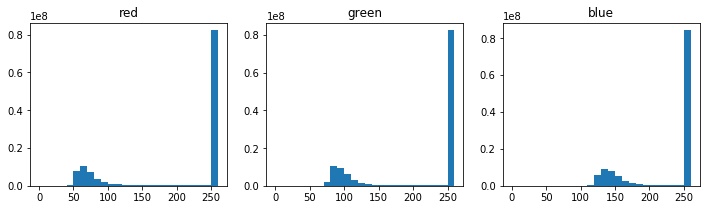

In [6]:
binz=np.arange(0,270,10)
size_m=np.shape(red)
fig,ax=plt.subplots(1,3,figsize=(12,3))

ax[0].hist(red.flatten(),bins=binz);
ax[0].set_title('red')
ax[1].hist(green.flatten(),bins=binz);
ax[1].set_title('green')
ax[2].hist(blue.flatten(),bins=binz);
ax[2].set_title('blue')


Okay, so clearly you can see theres a very obvious mode at bin 250-260. This is because the way the TCI is created and the bands are normalized and every value > 255 is set to 255. So these pixels are likely associated with ice (because they are so bright). So my first thought is to just set ice_pixel > 250 and see what happens:

initiate boolean array size of S2 image

In [7]:
ice_mask=np.zeros(size_m).astype(bool) 

set values in the ice_mask array as True if they are greater than 250.

In [8]:
ice_mask[red>250]=True 

So all the remaining pixels would be open water:

In [9]:
ow_mask= ~ice_mask

Now we recreate the image:

In [10]:
red_c= np.array(red,copy= True)
green_c= np.array(green,copy= True)
blue_c= np.array(blue,copy= True)

red_c[ice_mask]= 200
green_c[ice_mask]= 0
blue_c[ice_mask]= 0

# red_c[mp_mask]= 200
# green_c[mp_mask]= 200
# blue_c[mp_mask]= 0

red_c[ow_mask]= 0
green_c[ow_mask]= 0
blue_c[ow_mask]= 200

rgbArray = np.zeros((size_m[0],size_m[1],3), 'uint8')
rgbArray[..., 0] = red_c
rgbArray[..., 1] = green_c
rgbArray[..., 2] = blue_c
img = Image.fromarray(rgbArray,'RGB')
im_save3=file_path+y[:15]+'_test_class_TCI.png'
img.save(im_save3)

That worked really well for me. the ice and open water in your image are very distinct so it was easy to separate. In sets of images with non-uniform lighting of more complex surfaces (melt ponds, ice draft, or even land...) this process gets more complicated.